# Time Series Anomaly Detection using LSTM Autoencoders with PyTorch in Python

In [1]:
!nvidia-smi

Mon May 23 16:20:07 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.89       Driver Version: 465.89       CUDA Version: 11.3     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   55C    P8    11W /  N/A |    247MiB /  6144MiB |      6%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.1.1

numpy : 1.21.5
pandas: 1.4.2
torch : 1.11.0



In [3]:
import torch

import copy
import random
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from torch import nn, optim
from torchsummary import summary
from torch.utils.data import TensorDataset, DataLoader
from sklearn import preprocessing
import torch.nn.functional as F


%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8


RANDOM_SEED = 2022
def seed_everything(seed: int):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
seed_everything(RANDOM_SEED)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In this tutorial, you'll learn how to detect anomalies in Time Series data using an LSTM Autoencoder. You're going to use real-world ECG data from a single patient with heart disease to detect abnormal hearbeats.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

By the end of this tutorial, you'll learn how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

## Data



The [dataset](http://timeseriesclassification.com/description.php?Dataset=ECG5000) contains 5,000 Time Series examples (obtained with ECG) with 140 timesteps. Each sequence corresponds to a single heartbeat from a single patient with congestive heart failure.

> An electrocardiogram (ECG or EKG) is a test that checks how your heart is functioning by measuring the electrical activity of the heart. With each heart beat, an electrical impulse (or wave) travels through your heart. This wave causes the muscle to squeeze and pump blood from the heart. [Source](https://www.heartandstroke.ca/heart/tests/electrocardiogram)

We have 5 types of hearbeats (classes):

- Normal (N) 
- R-on-T Premature Ventricular Contraction (R-on-T PVC)
- Premature Ventricular Contraction (PVC)
- Supra-ventricular Premature or Ectopic Beat (SP or EB) 
- Unclassified Beat (UB).

> Assuming a healthy heart and a typical rate of 70 to 75 beats per minute, each cardiac cycle, or heartbeat, takes about 0.8 seconds to complete the cycle.
Frequency: 60–100 per minute (Humans)
Duration: 0.6–1 second (Humans) [Source](https://en.wikipedia.org/wiki/Cardiac_cycle)

The dataset is available on my Google Drive. Let's get it:

In [4]:
real_path = '../data/MA_1D/dataset_real.csv'
fake_path = '../data/MA_1D/dataset_fake.csv'

The data comes in multiple formats. We'll load the `arff` files into Pandas data frames:

In [5]:
df = pd.read_csv(fake_path, header=None)
df.rename(columns={1475: 'target'}, inplace=True)

In [6]:
scaler_fake = preprocessing.MinMaxScaler()
scaler_fake.fit(df.iloc[:,:-1].T)
df.iloc[:,:-1] = scaler_fake.transform(df.iloc[:,:-1].T).T

In [7]:
# train_df, val_df = train_test_split(df, test_size=0.2, random_state=seed, stratify=df['target'])
# train_df, val_df = train_df.reset_index(drop=True), val_df.reset_index(drop=True)

In [8]:
df.head()

,0,1,2,3,4,5,6,7,8,9,...,1466,1467,1468,1469,1470,1471,1472,1473,1474,target
0,0.629066,0.760201,0.778164,0.899937,0.861660,0.867468,0.835054,0.838107,0.821120,0.752540,...,0.168743,0.206727,0.247299,0.201669,0.192267,0.140230,0.086033,0.136816,0.174508,0.0
1,0.645220,0.799909,0.837331,0.942700,0.929944,0.913302,0.870686,0.873536,0.846765,0.807554,...,0.148582,0.181482,0.256133,0.203939,0.176171,0.135301,0.078514,0.131553,0.166641,0.0
2,0.649990,0.792388,0.829042,0.928829,0.895919,0.872732,0.841005,0.888481,0.840105,0.831460,...,0.169564,0.215052,0.246079,0.194844,0.185507,0.150858,0.082197,0.127070,0.171968,0.0
3,0.638569,0.779027,0.792120,0.909728,0.873052,0.865531,0.810838,0.857738,0.827300,0.829221,...,0.148568,0.183783,0.259311,0.181271,0.179279,0.157804,0.081186,0.119167,0.186129,0.0
4,0.636588,0.778076,0.788653,0.912466,0.887313,0.879024,0.846529,0.880682,0.860250,0.846361,...,0.175335,0.200140,0.282298,0.245369,0.223576,0.178630,0.110795,0.154794,0.192932,0.0


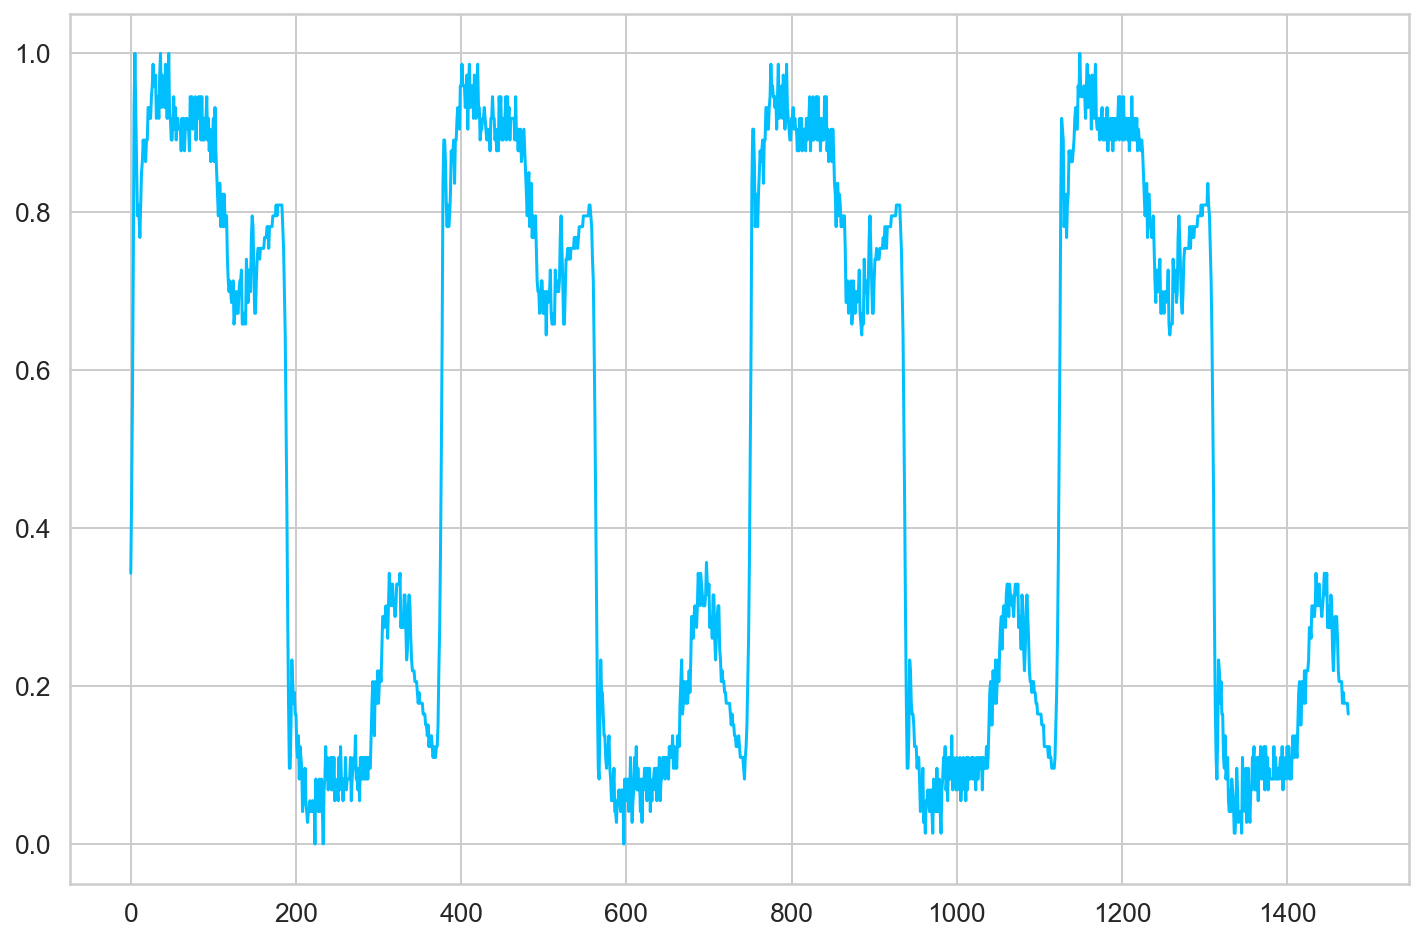

In [9]:
test_df = pd.read_csv(real_path, header=None)
test_df.rename(columns={1475: 'target'}, inplace=True)

scaler_real = preprocessing.MinMaxScaler()
scaler_real.fit(test_df.iloc[:,:-1].T)
test_df.iloc[:,:-1] = scaler_real.transform(test_df.iloc[:,:-1].T).T

test_df.reset_index(drop=True)
plt.plot(test_df.iloc[0,:-1])

We'll combine the training and test data into a single data frame. This will give us more data to train our Autoencoder. We'll also shuffle it:

In [10]:
df = df.append(test_df)
df = df.sample(frac=1.0)
df.head()

C:\Users\14598\AppData\Local\Temp\ipykernel_13504\1767135501.py:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(test_df)


,0,1,2,3,4,5,6,7,8,9,...,1466,1467,1468,1469,1470,1471,1472,1473,1474,target
150,0.460089,0.706873,0.785075,0.889638,0.918529,0.932335,0.927522,0.875097,0.838324,0.824828,...,0.191368,0.188813,0.184922,0.106854,0.214814,0.097257,0.075534,0.127925,0.239374,1.0
304,0.449349,0.718796,0.769556,0.943302,0.848219,0.876792,0.819011,0.783564,0.727604,0.765415,...,0.105776,0.106968,0.078880,0.150238,0.133397,0.114546,0.050314,0.047069,0.135658,2.0
43,0.339783,0.632704,0.621631,0.878390,0.962671,0.981521,0.948694,0.951870,0.843727,0.805292,...,0.131385,0.179446,0.173088,0.176559,0.184148,0.129155,0.117526,0.170792,0.208779,0.0
285,0.474252,0.733455,0.817503,0.887998,0.926164,0.907763,0.915229,0.837976,0.809011,0.779204,...,0.182968,0.167932,0.179815,0.108545,0.223860,0.108717,0.081610,0.121629,0.244846,1.0
114,0.438068,0.317415,0.408844,0.564204,0.764960,0.884676,0.963678,0.948432,0.925643,0.765598,...,0.225774,0.221535,0.137652,0.189691,0.123198,0.228063,0.156084,0.172843,0.225226,0.0


We have 5,000 examples. Each row represents a single heartbeat record. Let's name the possible classes:

In [11]:
CLASS_NORMAL = 1
class_names = ['Right','Normal','Left',]

id_to_class = {
    0.: "Left",
    1.: "Normal",
    2.: "Right",
}

class_to_id = {
    "Left": 0.,
    "Normal": 1.,
    "Right": 2.,
}

Next, we'll rename the last column to `target`, so its easier to reference it:

## Exploratory Data Analysis

Let's check how many examples for each heartbeat class do we have:

In [12]:
df.target.value_counts()

2.0    165
0.0    165
1.0    153
Name: target, dtype: int64

Let's plot the results:

E:\Anaconda\envs\pytorch_GPU\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0, 0, 'Right'), Text(1, 0, 'Normal'), Text(2, 0, 'Left')]

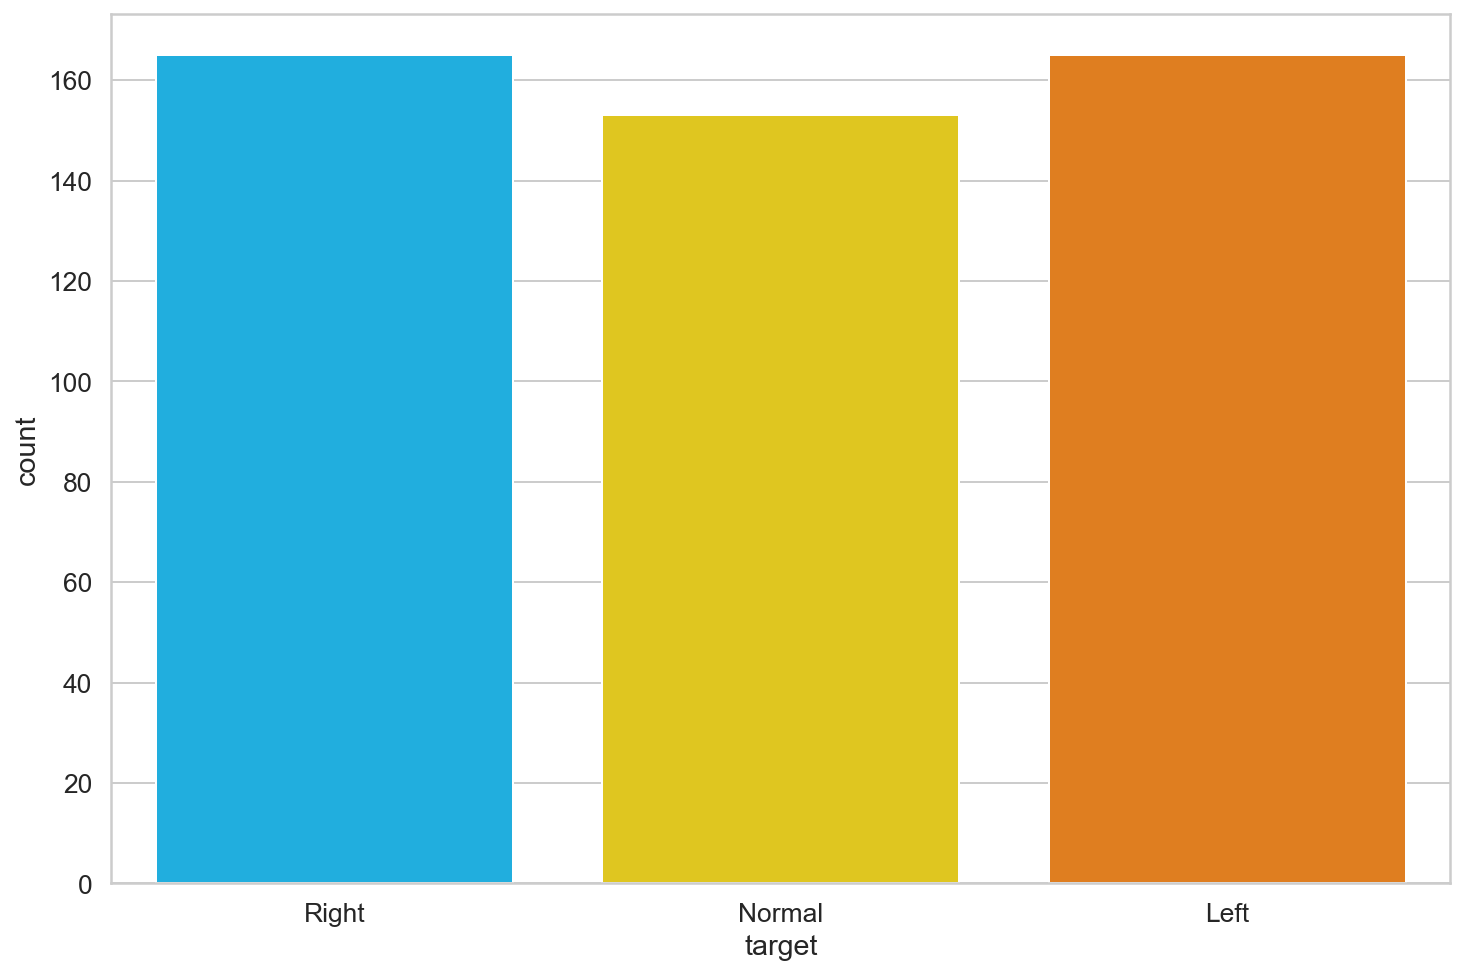

In [13]:
ax = sns.countplot(df.target)
ax.set_xticklabels(class_names)

The normal class, has by far, the most examples. This is great because we'll use it to train our model.

Let's have a look at an averaged (smoothed out with one standard deviation on top and bottom of it) Time Series for each class:

In [14]:
def plot_time_series_class(data, class_name, ax, n_steps=10):
  time_series_df = pd.DataFrame(data)

  smooth_path = time_series_df.rolling(n_steps).mean()
  path_deviation = 2 * time_series_df.rolling(n_steps).std()

  under_line = (smooth_path - path_deviation)[0]
  over_line = (smooth_path + path_deviation)[0]

  ax.plot(smooth_path, linewidth=2)
  ax.fill_between(
    path_deviation.index,
    under_line,
    over_line,
    alpha=.125
  )
  ax.set_title(class_name,fontsize=20)

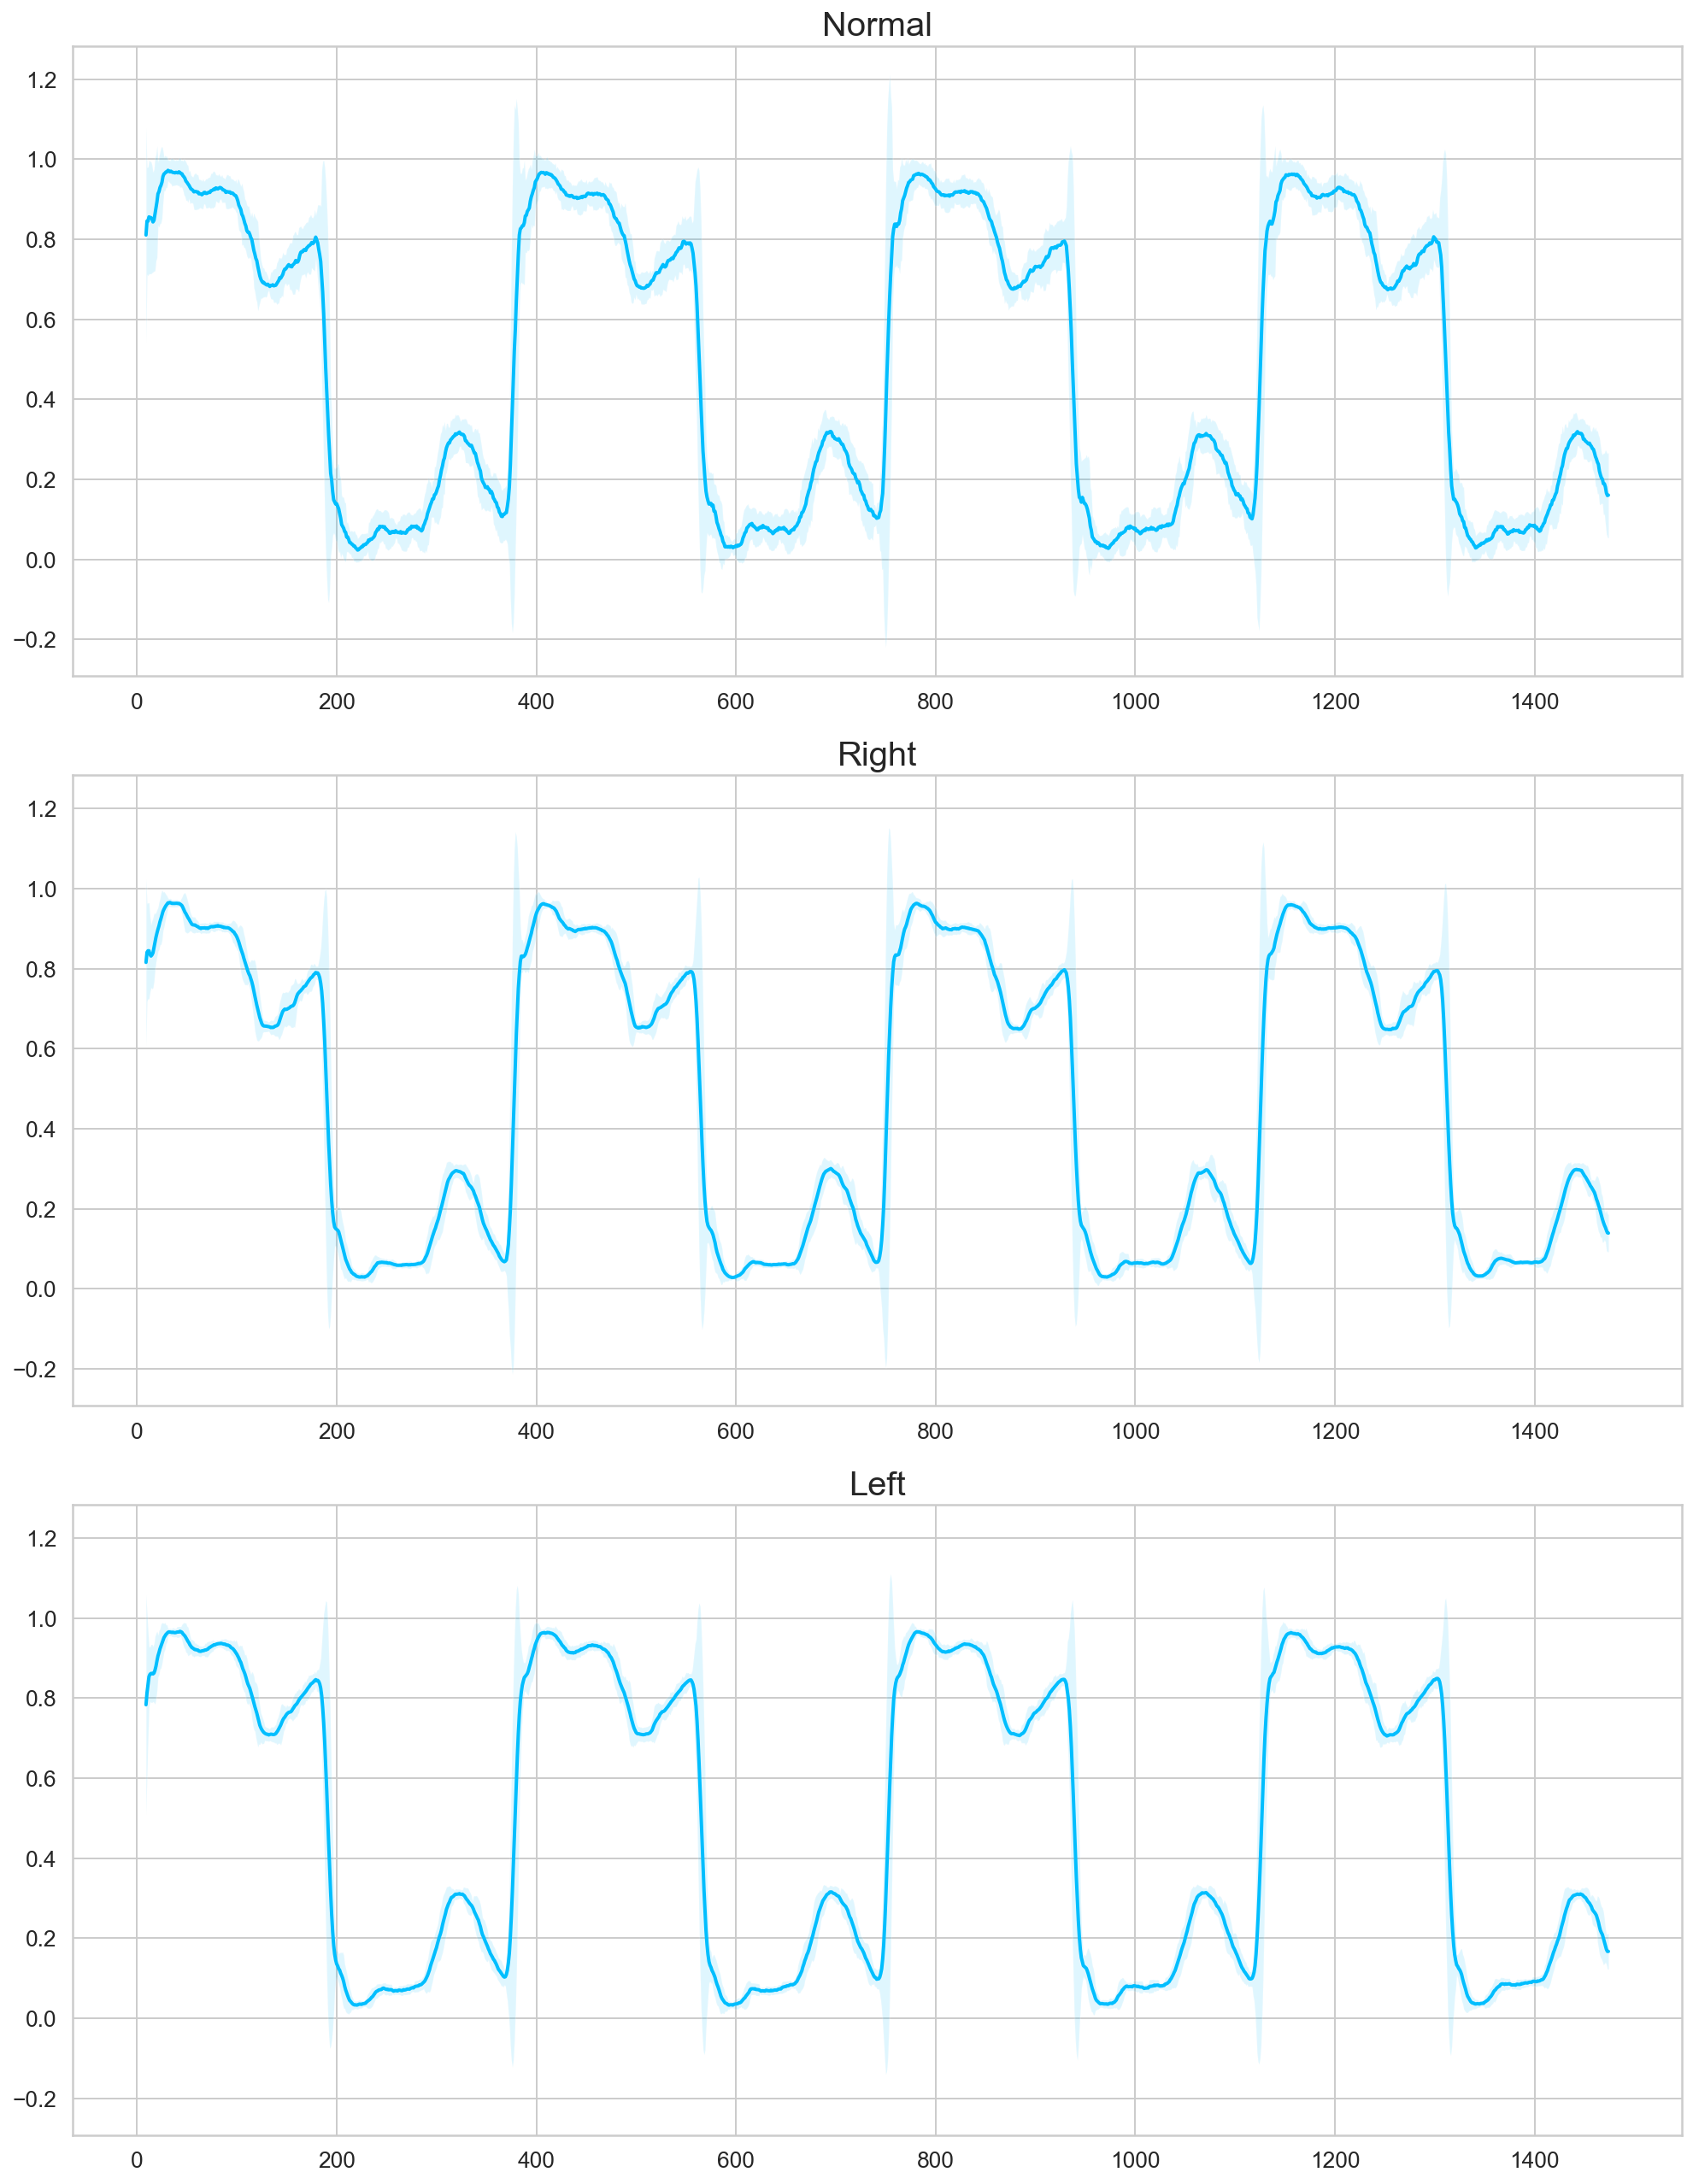

In [15]:
classes = df.target.unique()

fig, axs = plt.subplots(
  nrows=3,
  ncols=1,
  sharey=True,
  figsize=(14, 18),
)

for i, cls in enumerate(classes):
  ax = axs.flat[i]
  data = df[df.target == cls] \
    .drop(labels='target', axis=1) \
    .mean(axis=0) \
    .to_numpy()
  plot_time_series_class(data, id_to_class[cls], ax)

fig.tight_layout();

It is very good that the normal class has a distinctly different pattern than all other classes. Maybe our model will be able to detect anomalies?

## LSTM Autoencoder

The [Autoencoder's](https://en.wikipedia.org/wiki/Autoencoder) job is to get some input data, pass it through the model, and obtain a reconstruction of the input. The reconstruction should match the input as much as possible. The trick is to use a small number of parameters, so your model learns a compressed representation of the data.

In a sense, Autoencoders try to learn only the most important features (compressed version) of the data. Here, we'll have a look at how to feed Time Series data to an Autoencoder. We'll use a couple of LSTM layers (hence the LSTM Autoencoder) to capture the temporal dependencies of the data.

To classify a sequence as normal or an anomaly, we'll pick a threshold above which a heartbeat is considered abnormal.

### Reconstruction Loss

When training an Autoencoder, the objective is to reconstruct the input as best as possible. This is done by minimizing a loss function (just like in supervised learning). This function is known as *reconstruction loss*. Cross-entropy loss and Mean squared error are common examples.

## Anomaly Detection in ECG Data

We'll use normal heartbeats as training data for our model and record the *reconstruction loss*. But first, we need to prepare the data:

### Data Preprocessing

Let's get all normal heartbeats and drop the target (class) column:

In [16]:
normal_df = df[df.target == CLASS_NORMAL].drop(labels='target', axis=1)
normal_df.shape

(153, 1475)

We'll merge all other classes and mark them as anomalies:

In [17]:
anomaly_df = df[df.target != CLASS_NORMAL].drop(labels='target', axis=1)
anomaly_df.shape

(330, 1475)

We'll split the normal examples into train, validation and test sets:

In [18]:
train_df, val_df = train_test_split(
  normal_df,
  test_size=0.15,
  random_state=RANDOM_SEED
)

val_df, test_df = train_test_split(
  val_df,
  test_size=0.33,
  random_state=RANDOM_SEED
)

In [19]:
train_df.shape

(130, 1475)

In [20]:
val_df.shape

(15, 1475)

In [21]:
test_df.shape

(8, 1475)

We need to convert our examples into tensors, so we can use them to train our Autoencoder. Let's write a helper function for that:

In [22]:
def create_dataset(df, seq_size = 1):
  data_length = len(df.iloc[0])

  x_values = []
  y_values = []
  for i in range(len(df)):
    x = df.iloc[i]
    for i in range(data_length - seq_size):
          x_values.append(x.iloc[i:(i + seq_size)].values)
          y_values.append(x.iloc[i + seq_size])
  # sequences = df.astype(np.float32).to_numpy().tolist()

  x = [torch.tensor(x).unsqueeze(1).float() for x in x_values]
  y = [torch.tensor(y).unsqueeze(0).float() for y in y_values]

  x = torch.stack(x)
  y = torch.stack(y)
  print(x.shape,y.shape)

  n_seq, seq_len, n_features = x.shape

  return x, y, seq_len, n_features

Each Time Series will be converted to a 2D Tensor in the shape *sequence length* x *number of features* (140x1 in our case).

Let's create some datasets:

In [23]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)
print(anomaly_df.shape)

(130, 1475)
(15, 1475)
(8, 1475)
(330, 1475)


In [24]:
seq_size = 120  # Number of time steps to look back
trainX, trainY, seq_len, n_features = create_dataset(train_df, seq_size)
valX, valY, _, _ = create_dataset(val_df, seq_size)
test_normal_X, test_normal_Y, _, _ = create_dataset(test_df, seq_size)
test_anomaly_X, test_anomaly_Y, _, _ = create_dataset(anomaly_df, seq_size)

torch.Size([176150, 120, 1]) torch.Size([176150, 1])
torch.Size([20325, 120, 1]) torch.Size([20325, 1])
torch.Size([10840, 120, 1]) torch.Size([10840, 1])
torch.Size([447150, 120, 1]) torch.Size([447150, 1])


In [25]:
print(trainY.shape)
trainX[:2]
trainY[:2]

torch.Size([176150, 1])


tensor([[0.7160],
        [0.6562]])

In [26]:
batch_size = 32
trainDataset = TensorDataset(trainX, trainY)
trainDataloader = DataLoader(trainDataset, batch_size=batch_size, shuffle=True)

valDataset = TensorDataset(valX, valY)
valDataloader = DataLoader(valDataset, batch_size=batch_size, shuffle=True)


testNormalDataset = TensorDataset(test_normal_X, test_normal_Y)
testNormalDataloader = DataLoader(testNormalDataset, batch_size=batch_size, shuffle=True)

testAnomalyDataset = TensorDataset(test_anomaly_X, test_anomaly_Y)
testAnomalyDataloader = DataLoader(testAnomalyDataset, batch_size=batch_size, shuffle=True)

The general Autoencoder architecture consists of two components. An *Encoder* that compresses the input and a *Decoder* that tries to reconstruct it.

We'll use the LSTM Autoencoder from this [GitHub repo](https://github.com/shobrook/sequitur) with some small tweaks. Our model's job is to reconstruct Time Series data. Let's start with the *Encoder*:

In [27]:
class Encoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64, dropout=0):
    super(Encoder, self).__init__()

    self.seq_len = seq_len #60
    self.n_features = n_features #1
    self.embedding_dim = embedding_dim  #128
    self.hidden_dim = 2 * embedding_dim #256

    self.rnn1 = nn.LSTM(
      input_size=n_features,  #1
      hidden_size=self.hidden_dim, #256
      num_layers=1,
      batch_first=True
    )
    
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,  #256
      hidden_size=embedding_dim,  #128
      num_layers=1,
      batch_first=True
    )

  def forward(self, x):
    # print(x.shape)
    x = x.reshape((x.shape[0], self.seq_len, self.n_features))
    # print(x.shape)
    x, (_, _) = self.rnn1(x)
    # print(x.shape)
    x, (hidden_n, _) = self.rnn2(x)
    # print(x.shape)
    # print(hidden_n.shape)
    return hidden_n.reshape((x.shape[0],self.n_features, self.embedding_dim))

The *Encoder* uses two LSTM layers to compress the Time Series data input.

Next, we'll decode the compressed representation using a *Decoder*:

In [28]:
class Decoder(nn.Module):

  def __init__(self, seq_len, input_dim=64, n_features=1, dropout=0):
    super(Decoder, self).__init__()

    self.seq_len = seq_len #60
    self.input_dim = input_dim #128
    self.hidden_dim = 2 * input_dim #256
    self.n_features = n_features #1

    self.rnn1 = nn.LSTM(
      input_size=input_dim,#128
      hidden_size=input_dim,#128
      num_layers=1,
      batch_first=True
    )

    self.rnn2 = nn.LSTM(
      input_size=input_dim,#128
      hidden_size=self.hidden_dim,#256
      num_layers=1,
      batch_first=True
    )

    self.output_layer = nn.Linear(self.hidden_dim, n_features)

  def forward(self, x):
    # print(x.shape)

    x = x.repeat(1, self.seq_len, 1)
    # print(x.shape)
    # x = x.reshape(x.shape[1], self.n_features, self.seq_len, self.input_dim)
    x, (hidden_n, cell_n) = self.rnn1(x)
    # print(x.shape)
    x, (hidden_n, cell_n) = self.rnn2(x)
    # print(x.shape)
    # x = x.reshape((self.seq_len, self.hidden_dim))
    x = self.output_layer(x)
    # print(x.shape)
    # x = x[:,-1,0]
    # print(x.shape)

    return x

Our Decoder contains two LSTM layers and an output layer that gives the final reconstruction.

Time to wrap everything into an easy to use module:

In [29]:
class RecurrentAutoencoder(nn.Module):

  def __init__(self, seq_len, n_features, embedding_dim=64, dropout=0):
    super(RecurrentAutoencoder, self).__init__()

    self.encoder = Encoder(seq_len, n_features, embedding_dim, dropout).to(device)
    print(self.encoder)
    self.decoder = Decoder(seq_len, embedding_dim, n_features, dropout).to(device)
    print(self.decoder)

  def forward(self, x):
    x = self.encoder(x)
    x = self.decoder(x)

    return x

Our Autoencoder passes the input through the Encoder and Decoder. Let's create an instance of it:

In [30]:
model = RecurrentAutoencoder(seq_len, n_features, 128, dropout=0.2)
model = model.to(device)

Encoder(
  (rnn1): LSTM(1, 256, batch_first=True)
  (rnn2): LSTM(256, 128, batch_first=True)
)
Decoder(
  (rnn1): LSTM(128, 128, batch_first=True)
  (rnn2): LSTM(128, 256, batch_first=True)
  (output_layer): Linear(in_features=256, out_features=1, bias=True)
)


## Training

Let's write a helper function for our training process:

In [33]:
def train_model(model, train_dataset, val_dataset, n_epochs):
  optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
  criterion = nn.L1Loss(reduction='sum').to(device)
  history = dict(train=[], val=[])

  best_model_wts = copy.deepcopy(model.state_dict())
  best_loss = 10000.0


  for epoch in range(1, n_epochs + 1):
    model = model.train()
    train_losses = []
    for id_batch, (x_batch, y_batch) in enumerate(trainDataloader):
      optimizer.zero_grad()
      x_batch = x_batch.to(device)
      seq_pred = model(x_batch)

      loss = criterion(seq_pred, x_batch)

      loss = loss / batch_size
      loss.backward()
      optimizer.step()

      loss = loss.item()
      train_losses.append(loss)
      if id_batch%100 == 0:
        print(f'id/train_Epoch {id_batch}/{epoch}: '
              f'train loss {loss}')
    model = model.eval()
    val_losses = []
    with torch.no_grad():
      for id_batch, (x_batch, y_batch) in enumerate(valDataloader):
        x_batch = x_batch.to(device)
        seq_pred = model(x_batch)
        loss = criterion(seq_pred, x_batch)

        loss = loss.item() / batch_size
        val_losses.append(loss)
        if id_batch%100 == 0:
          print(f'id/val_Epoch {id_batch}/{epoch}: '
                f'val loss {loss}')

    train_loss = np.mean(train_losses)
    val_loss = np.mean(val_losses)

    history['train'].append(train_loss)
    history['val'].append(val_loss)

    if val_loss < best_loss:
      best_loss = val_loss
      best_model_wts = copy.deepcopy(model.state_dict())

    print(f'Epoch {epoch}: train loss {train_loss} val loss {val_loss}')

  model.load_state_dict(best_model_wts)
  return model.eval(), history

At each epoch, the training process feeds our model with all training examples and evaluates the performance on the validation set. Note that we're using a batch size of 1 (our model sees only 1 sequence at a time). We also record the training and validation set losses during the process.

Note that we're minimizing the [L1Loss](https://pytorch.org/docs/stable/nn.html#l1loss), which measures the MAE (mean absolute error). Why? The reconstructions seem to be better than with MSE (mean squared error).

We'll get the version of the model with the smallest validation error. Let's do some training:

In [34]:
model, history = train_model(
  model, 
  trainX,
  valX,
  n_epochs=5
)

id/train_Epoch 0/1: train loss 25.810821533203125
id/train_Epoch 100/1: train loss 21.309894561767578



KeyboardInterrupt



In [ ]:
ax = plt.figure().gca()

ax.plot(history['train'])
ax.plot(history['val'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'test'])
plt.title('Loss over training epochs')
plt.show();

Our model converged quite well. Seems like we might've needed a larger validation set to smoothen the results, but that'll do for now.

## Saving the model

Let's store the model for later use:

In [ ]:
MODEL_PATH = 'model.pth'

torch.save(model, MODEL_PATH)

Uncomment the next lines, if you want to download and load the pre-trained model:

## Choosing a threshold

With our model at hand, we can have a look at the reconstruction error on the training set. Let's start by writing a helper function to get predictions from our model:

Our function goes through each example in the dataset and records the predictions and losses. Let's get the losses and have a look at them:

In [68]:
def predict(model, dataset):
  predictions, losses = [], []
  criterion = nn.L1Loss(reduction='sum').to(device)

  with torch.no_grad():
    model = model.eval()
    for id, x in enumerate(dataset):
      x = x.unsqueeze(0).to(device)
      seq_pred = model(x)

      loss = criterion(seq_pred, x)
      predictions.append(seq_pred.cpu().numpy().flatten())
      losses.append(loss.item())
  return predictions, losses

In [ ]:
def plot_prediction(data, model, title, ax):
  predictions, pred_losses = predict(model, [data])
  ax.plot(data, label='true', linewidth = 5)
  ax.plot(predictions[0], label='reconstructed', linewidth = 5)
  ax.set_title(f'{title} (loss: {np.around(pred_losses[0], 2)})',fontsize = 40)
  ax.legend(prop={"size":40})

In [ ]:
fig, axs = plt.subplots(
nrows=2,
ncols=1,
sharey=True,
sharex=True,
figsize=(22, 22)
)

for i, data in enumerate(test_normal_X[:1]):
  plot_prediction(data, model, title='Normal', ax=axs[0])

for i, data in enumerate(test_anomaly_X[:1]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1])

fig.tight_layout()
fig.show()

In [ ]:
_, losses = predict(model, trainX[:10000])

sns.histplot(losses, bins=50, kde=True);

In [ ]:
print(losses)

In [ ]:
THRESHOLD = 7

## Evaluation

Using the threshold, we can turn the problem into a simple binary classification task:

- If the reconstruction loss for an example is below the threshold, we'll classify it as a *normal* heartbeat
- Alternatively, if the loss is higher than the threshold, we'll classify it as an anomaly

### Normal hearbeats

Let's check how well our model does on normal heartbeats. We'll use the normal heartbeats from the test set (our model haven't seen those):

In [ ]:
predictions, pred_losses = predict(model, test_normal_X)
sns.histplot(pred_losses, bins=50, kde=True);

We'll count the correct predictions:

In [ ]:
correct = sum(l <= THRESHOLD for l in pred_losses)
print(f'Correct normal predictions: {correct}/{len(test_normal_X)}')

### Anomalies

We'll do the same with the anomaly examples, but their number is much higher. We'll get a subset that has the same size as the normal heartbeats:

In [ ]:
print(len(test_anomaly_X))
test_anomaly_X = test_anomaly_X[:len(test_normal_X)]

Now we can take the predictions of our model for the subset of anomalies:

In [ ]:
predictions, pred_losses = predict(model, test_anomaly_X)
sns.histplot(pred_losses, bins=50, kde=True);

Finally, we can count the number of examples above the threshold (considered as anomalies):

In [ ]:
correct = sum(l > THRESHOLD for l in pred_losses)
print(f'Correct anomaly predictions: {correct}/{len(test_anomaly_X)}')

We have very good results. In the real world, you can tweak the threshold depending on what kind of errors you want to tolerate. In this case, you might want to have more false positives (normal heartbeats considered as anomalies) than false negatives (anomalies considered as normal).

#### Looking at Examples

We can overlay the real and reconstructed Time Series values to see how close they are. We'll do it for some normal and anomaly cases:

In [ ]:
fig, axs = plt.subplots(
  nrows=2,
  ncols=1,
  sharey=True,
  sharex=True,
  figsize=(22, 22)
)

for i, data in enumerate(test_normal_X[:1]):
  plot_prediction(data, model, title='Normal', ax=axs[0])

for i, data in enumerate(test_normal_X[:1]):
  plot_prediction(data, model, title='Anomaly', ax=axs[1])

fig.tight_layout();

## Summary

In this tutorial, you learned how to create an LSTM Autoencoder with PyTorch and use it to detect heartbeat anomalies in ECG data.

- [Read the tutorial](https://www.curiousily.com/posts/time-series-anomaly-detection-using-lstm-autoencoder-with-pytorch-in-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1_J2MrBSvsJfOcVmYAN2-WSp36BtsFZCa)
- [Read the Getting Things Done with Pytorch book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You learned how to:

- Prepare a dataset for Anomaly Detection from Time Series Data
- Build an LSTM Autoencoder with PyTorch
- Train and evaluate your model
- Choose a threshold for anomaly detection
- Classify unseen examples as normal or anomaly

While our Time Series data is univariate (we have only 1 feature), the code should work for multivariate datasets (multiple features) with little or no modification. Feel free to try it!

## References

- [Sequitur - Recurrent Autoencoder (RAE)](https://github.com/shobrook/sequitur)
- [Towards Never-Ending Learning from Time Series Streams](https://www.cs.ucr.edu/~eamonn/neverending.pdf)
- [LSTM Autoencoder for Anomaly Detection](https://towardsdatascience.com/lstm-autoencoder-for-anomaly-detection-e1f4f2ee7ccf)